In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import (model_to_hdulist, obs_coronagraphy)
from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARN', verbose=False)

from astropy.io import (fits, ascii)
from copy import deepcopy

## Observation Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def obs_wfe(wfe_ref_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations.
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    fov_pix_orig = fov_pix
        
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if args_disk is not None:
            # Convert to photons/sec in specified filter
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)

        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        if mask is None:
            subsize = 400
        elif ('MASK210R' in mask) or ('MASKSWB' in mask):
            subsize = 640
        else:
            subsize = 320
        fov_pix = subsize if fov_pix is None else fov_pix
        
        # Offset for bar mask
        if (mask is not None) and ('WB' in mask):
            offset_r, offset_theta = offset_bar(filt, mask)
        else:
            offset_r, offset_theta = (None, None)

        # Other coronagraph vs direct imaging settings
        if mask is None:
            module = 'B'
            oversample = 4
        else:
            module = 'A'
            oversample = 2
            
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = obs_coronagraphy(sp_sci, sp_ref, dist, module=module, disk_hdu=hdu_disk, 
                                         wfe_ref_drift=wfe_ref_drift, filter=filt, mask=mask, pupil=pupil, 
                                         wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                         offset_r=offset_r, offset_theta=offset_theta,
                                         oversample=oversample, fov_pix=fov_pix, verbose=verbose)
        fov_pix = fov_pix_orig
    return obs_dict

## Functions to init, optimize, and plot

In [5]:
# Generate initial observations for each filter(no WFE drift)
def do_init(args_disk=None, fov_pix=None, verbose=True):
    wfe_ref_drift = 0
    obs_dict = obs_wfe(wfe_ref_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       args_disk=args_disk, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [6]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, **kwargs):
    """
    kwargs to pass to calc_contrast() and their defaults:

    exclude_disk = True
    exclude_planets = True
    exclude_noise = False
    opt_diff = True
    """
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_ref_drift in wfe_list:
            obs.wfe_ref_drift = wfe_ref_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, **kwargs)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [7]:
def do_gen_hdus(obs_dict, wfe_ref_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_ref_drift = wfe_ref_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

In [8]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_ref_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label='$\Delta$' + "WFE = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax

def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25], **kwargs):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s', **kwargs)
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25], **kwargs):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    #lin_vals = np.linspace(0,0.5,4)
    #cols = plt.cm.Purples_r(lin_vals)[::-1]
    
    dist = obs.distance
    
    if entropy<8: entropy=8
    if entropy>13: entropy=13

    pmag = planet_mags(obs, age, entropy, mass_list, av_vals, **kwargs)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, "Warm")
    ent_str = entropy_string + ' Start'
    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])

    ax.set_title('{} -- {} {}'.format(obs.filter,ent_str,av_str))


In [9]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    dist = obs.distance
    age_str = 'Age = {:.0f} Myr'.format(age)
    dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''
    
    fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Define Source and their Reference Counterparts

In [10]:
#                source,      dist, age, sptype, kmag
args_sources = [('SAO 206462', 140,  10, 'F8V',   5.8),
                ('TW Hya',      54,  10, 'M0V',   7.3),
                ('MWC 758',    150,   5, 'A5V',   5.7), # Lazareff et al. (2016)
                ('HL Tau',     140,   1, 'K5V',   7.4)]

# Corresponding reference stars
ref_sources =  [('HD 94771', 'G4V', 5.6),
                ('HD 94771', 'G4V', 5.6),
                ('HR 1889',  'F5III', 5.4),
                ('HR 1889',  'F5III', 5.4)]

In [11]:
# 2MASS K-Band
bp_k = pynrc.bp_2mass('k')

# List of filters
args_list =  [('F187N', None, None),
              ('F200W', None, None),
              ('F356W', None, None),
              ('F444W', None, None)]

args_list =  [('F356W', None, None),
              ('F444W', None, None)]


args_list =  [('F356W', None, None),
              ('F444W', None, None),
              ('F356W', 'MASK430R', 'CIRCLYOT'),
              ('F444W', 'MASK430R', 'CIRCLYOT')]


filt_keys = []
for (filt,mask,pupil) in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

### 1. SAO 206462

In [12]:
i = 0

name_sci, dist_sci, age_sci, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k)
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_sci.name = name_sci
sp_ref.name = name_ref

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [13]:
obs_dict = do_init(args_disk=args_disk, fov_pix=256, verbose=True)

F356W None None
Generating list of PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W None None
Generating list of PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F356W MASK430R CIRCLYOT
Generating list of PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W MASK430R CIRCLYOT
Generating list of PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [14]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,200,250)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(obs.multiaccum_times)

{'t_frame': 1.65624, 't_group': 1.65624, 't_int': 8.2812, 't_exp': 1656.24, 't_acq': 1991.6079999999997, 't_int_tot': 9.958039999999999}
{'t_frame': 1.65624, 't_group': 1.65624, 't_int': 8.2812, 't_exp': 1656.24, 't_acq': 1991.6079999999997, 't_int_tot': 9.958039999999999}
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1571.4887999999999, 't_acq': 1587.8231999999998, 't_int_tot': 105.85488}
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1571.4887999999999, 't_acq': 1587.8231999999998, 't_int_tot': 105.85488}


In [22]:
# List of WFE drifts to check
wfe_list = [0,2,5,10][::-1]
nsig = 5

save_fig = True
multi_fig = True

curves_dict = do_contrast(wfe_list, filt_keys, nsig=nsig)

F356W_none_none
F444W_none_none
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


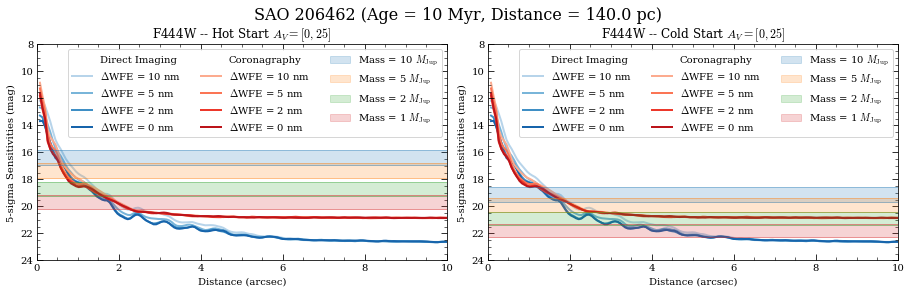

In [40]:
# Compare F444W direct imaging vs coronagraphy

age = age_sci
kind = [1,3]
nwfe = len(wfe_list)

fig, axes = plt.subplots(1,2, figsize=(13,4.0))
entropy_vals = [13,8]

xlim=[0,10]
ylim=[24,8]

lin_vals = np.linspace(0.2,0.7,nwfe)
cb = plt.cm.Blues_r(lin_vals)[::-1]
cr = plt.cm.Reds_r(lin_vals)[::-1]


for i, ind in enumerate(kind):
    key = filt_keys[ind]
    obs = obs_dict[key]
    curves = curves_dict[key]

    for j, ax in enumerate(axes.flatten()):
        colors = cb if i==0 else cr

        plot_contrasts(curves, wfe_list, ax=ax, colors=colors)

for j, ax in enumerate(axes.flatten()):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe]
    h2 = handles[nwfe:2*nwfe]
    h3 = handles[2*nwfe:]
    h1_t = [patches.Patch(color='none', label='Direct Imaging')]
    h2_t = [patches.Patch(color='none', label='Coronagraphy')]
    handles = h1_t + h1 + h2_t + h2 + h3

    ax.legend(ncol=3, handles=handles)

    #ax.legend(ncol=3)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

outdir = '/Users/Jarron/Desktop/JWST-PP/'
fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)
